# Day 17: Trick Shot

In [383]:
import re
import itertools

from PIL import Image, ImageDraw

## Max range with velocity x

if velocity in $X$ axis is $n$, the maximun length the probe is going to reach in axis $X$ is:

$$ n + (n-1) + (n-2) + \ldots + 1 $$

In other form:

$$ \frac{n \cdot (n+1)}{2} $$

This means that all values for the $X$ velocity that never gets a final length of the minimun $X$ coordinate of the target area can be discarted.
For example, as the target area of the sample starts in $20$, this means we can ignore every value $x$ that:

$$ \frac{x \cdot (x+1)}{2} < 20 \implies x \cdot (x+1) < 40 $$

We can substitute in the inequation $x \cdot (x+1)$ by $x \cdot x$, because:

$$ x \cdot x < x \cdot (x+1) $$

So:

$$ x \cdot x < 40 \implies x^2 < 40 \implies x < \sqrt{40}$$

The general formulae for the minimun value of the $X$ velocity to reach distance $d$ is:

$$ \left \lfloor{ \sqrt{2 \cdot d} }\right \rfloor  $$

In the example:

$$ \left \lfloor{ \sqrt{2 \cdot 20} }\right \rfloor  \implies \left \lfloor{ \sqrt{40} }\right \rfloor = 6 $$


All the possible values for velocity in $X$ axis are in a range between the previous calculated value and the maximun $X$ coordinate of the target area. In the
sample:

$$ [ 6 \ldots 30 ] $$

#### For all the posible values of (positive) speed in $Y$ axis, in some point we will be again in $x = 0$

We need the minimun possible value in $X$ speed (For the example, this is $6$). Eventually we are going back to $Y = 0$, because is a parabole. The value on $x$ is now in range and is fixed. Possible values for Y are now all the y values in the target. We need the maximum speed in $Y$ (Because we want to erach the highst altitude) that still is in the target zone, and this is going to be the deepest value  minus one (The gravity is going to accelerate in uno unit, so if we take 10, the position on $Y$ is going to be $11$). For the example, speed in axis $Y$ needs to be $9$.

In [341]:
def load_input(filename):
    pat_dta = re.compile(r'target area: x=(-?\d+)..(-?\d+), y=(-?\d+)..(-?\d+)')
    with open(filename) as fr:
        line = fr.readline().strip()
        m = pat_dta.match(line)
        return (
            int(m.group(1)),  # Min x
            int(m.group(3)),  # Min y
            int(m.group(2)),  # Max x
            int(m.group(4)),  # Max y
        )

In [342]:
min_x, min_y, max_x, max_y = load_input('17-sample.txt')
assert min_x == 20
assert max_x == 30
assert min_y == -10
assert max_y == -5

In [343]:
def shoot(delta_x, delta_y, steps=10):
    x = y = 0
    for step in range(steps):
        x += delta_x
        y += delta_y
        yield x, y
        if delta_x > 0:
            delta_x -= 1
        delta_y -= 1

assert list(shoot(7, 2, steps = 7)) == [
    (7, 2),
    (13, 3),
    (18, 3),
    (22, 2),
    (25, 0),
    (27, -3),
    (28, -7),
]

In [369]:
def bounding_box(min_x, min_y, max_x, max_y):
    from_x = min(min_x, 0) - 10
    to_x = max_x + 10
    from_y = min(min_y, 0) - 10
    to_y = max_y + 10
    return (
        from_x, 
        from_y,
        to_x,
        to_y,
    )
min_x, min_y, max_x, max_y = load_input('17-sample.txt')
assert min_x == 20
assert min_y == -10
assert max_x == 30
assert max_y == -5
min_x, min_y, max_x, max_y = bounding_box(min_x, min_y, max_x, max_y)
assert min_x == -10
assert min_y == -20
assert max_x == 40
assert max_y == 5

Max height: -1


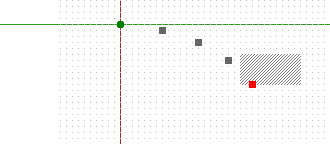

In [458]:
class DrawWorld:
    
    def __init__(self, min_x, min_y, max_x, max_y, factor=4):
        self.factor = factor
        self.target = [(min_x, min_y), (max_x, max_y)]
        self.reshape(*bounding_box(min_x, min_y, max_x, max_y))
        
    def reshape(self, min_x, min_y, max_x, max_y):
        self.min_x = min_x
        self.min_y = min_y
        self.max_x = max_x
        self.max_y = max_y
        self.width = max_x - min_x
        self.height = max_y - min_y
        self.offset_y = self.height + self.min_y
        self.offset_x = -self.min_y
        self.size = (self.width, self.height)
    
    def scale_x(self, x):
        return (self.offset_x + x) * self.factor

    def scale_y(self, y):
        return (self.offset_y - y) * self.factor
    
    def scale(self, x, y):
        return (self.scale_x(x), self.scale_y(y))

    def in_target(self, x, y):
        ((x0, y0), (x1, y1)) = self.target
        return (x0 <= x <= x1) and (y0 <= y <= y1)
    
    def box(self, x, y):
        box_half_size = self.factor // 2
        x, y = self.scale(x, y)
        return(x-box_half_size, y-box_half_size, x+box_half_size, y+box_half_size)
        
    def dot(self, draw, x, y, color="#666666"):
        if self.in_target(x, y):
            color = "red"
        draw.rectangle(self.box(x, y), fill=color)
        
    def circle(self, draw, x, y, color="#f0327a"):
        draw.ellipse(self.box(x, y), fill=color)

    def rectangle(self, draw, box, color="#f0887a"):
        p0, p1 = box
        x0, y0 = self.scale(*p0)
        x1, y1 = self.scale(*p1)
        draw.rectangle([x0, y0, x1, y1], outline=color)
        for y in range(y1, y0+1):
            for x in range(x0, x1+1):
                if (x + y) % 6 in (2, 5, 8):
                    draw.point((x, y), fill="gray")
                else:
                    draw.point((x, y), fill="white")

    def axis(self, draw):
        draw.line(
            (
                0,
                self.offset_y*self.factor,
                self.width*self.factor,
                self.offset_y*self.factor
            ), fill='#339922'
        )
        draw.line(
            (
                self.offset_x*self.factor,
                0,
                self.offset_x*self.factor,
                self.height*self.factor
            ), fill='#993322'
        )
        if self.factor > 2:
            for y in range(self.min_y, self.max_y+1):
                for x in range(self.min_x, self.max_x+1):
                    draw.point(self.scale(x, y), fill="silver")
        self.circle(draw, 0, 0, "green")        
        
    def draw(self, points=None):
        points = points or []
        img = Image.new('RGBA', (self.width*self.factor, self.height*self.factor))
        draw = ImageDraw.Draw(img)
        self.axis(draw)
        self.rectangle(draw, self.target)
        for x, y in points:
            self.dot(draw, x, y)
        return img

(x0, y0, x1, y1) = load_input('17-sample.txt')
world = DrawWorld(x0, y0, x1, y1, factor=6)
marks = list(itertools.takewhile(lambda p: p[1] >= y0, shoot(7, -1, steps = 200)))
max_height = max(p[1] for p in marks)
world.reshape(world.min_x, world.min_y, world.max_x+5, max_height+5)
print(f'Max height: {max_height}')
img = world.draw(marks)
img

20 -10 30 -5


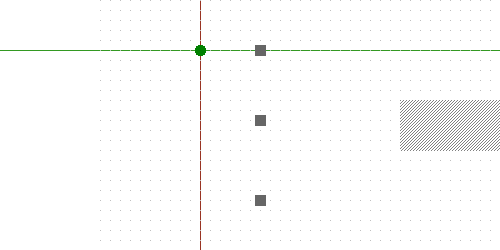

In [456]:
min_x, max_x, min_y, max_y = load_input('17-sample.txt')
marks = list(shoot(3, 6, steps = (6*7)//2))
print(min_x, max_x, min_y, max_y)
world = DrawWorld(min_x, max_x, min_y, max_y, factor=10)
img = world.draw(marks)
img

Max height: -1


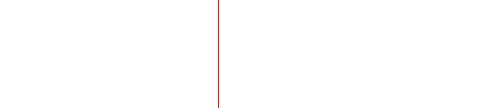

In [455]:
world_coords = load_input('17-input.txt')
world = DrawWorld(*world_coords,factor=2)
marks = list(shoot(7, -1, steps = 3))
print('Max height:', max(p[1] for p in marks))
img = world.draw(marks)
img

In [217]:
import math
min_x, max_x, min_y, max_y = load_input('17-sample.txt')
print(min_x)
math.trunc(math.sqrt(min_x * 2))

20


6

In [192]:
19*20//2

190

## Solution part one

In [245]:
import math

def find_solution(filename):
    min_x, max_x, min_y, max_y = load_input(filename)
    
    def in_target(x, y):
        return (min_x <= x <= max_x) and (min_y <= y <= max_y)
    
    vel_x  = math.trunc(math.sqrt(min_x * 2))
    print(f"Velocity in x: {vel_x}")
    vel_y = abs(min_y) - 1
    print(f"Velocity in y: {vel_y}")
    marks = list(shoot(vel_x, vel_y, steps=vel_x**2))
    assert any(in_target(p[0], p[1]) for p in marks)
    return max(p[1] for p in marks)

sol = find_solution('17-sample.txt')
assert sol == 45

Velocity in x: 6
Velocity in y: 9


In [246]:
sol = find_solution('17-input.txt')
print(f"Solution part one: {sol}")

Velocity in x: 20
Velocity in y: 98
Solution part one: 4851


## Solution part two

Range of posible solution for target defined from $x_0, y_0$ to $x_1, y_1$:

For x:

$$ [\sqrt{2 \cdot x_0 } \ldots x1] $$

For y:

$$ [y0-1 \ldots y1-1] $$


In [450]:
SOLS = [
    (23,-10),
    (25,-9),
    (27,-5),
    (29,-6),
    (22,-6),
    (21,-7),
    (9,0),
    (27,-7),
    (24,-5),
    (25,-7  ),
    (26,-6),
    (25,-5),
    (6,8),
    (11,-2),
    (20,-5),
    (29,-10),
    (6,3),
    (28,-7),
    (8,0    ),
    (30,-6),
    (29,-8),
    (20,-10),
    (6,7),
    (6,4),
    (6,1),
    (14,-4),
    (21,-6),
    (26,-10),
    (7,-1),
    (7,7),
    (8,-1),
    (21,-9),
    (6,2),
    (20,-7),
    (30,-10),
    (14,-3),
    (20,-8),
    (13,-2),
    (7,3),
    (28,-8),
    (29,-9),
    (15,-3),
    (22,-5),
    (26,-8),
    (25,-8),
    (25,-6),
    (15,-4),
    (9,-2),
    (15,-2),
    (12,-2),
    (28,-9),
    (12,-3),
    (24,-6),
    (23,-7),
    (25,-10 ),
    (7,8),
    (11,-3),
    (26,-7),
    (7,1),
    (23,-9),
    (6,0),
    (22,-10),
    (27,-6),
    (8,1),
    (22,-8),
    (13,-4),
    (7,6),
    (28,-6),
    (11,-4),
    (12,-4),
    (26,-9),
    (7,4),
    (24,-10),
    (23,-8),
    (30,-8),
    (7,0),
    (9,-1),
    (10,-1),
    (26,-5),
    (22,-9),
    (6,5),
    (7,5),
    (23,-6),
    (28,-10),
    (10,-2),
    (11,-1),
    (20,-9),
    (14,-2),
    (29,-7),
    (13,-3),
    (23,-5  ),
    (24,-8),
    (27,-9),
    (30,-7),
    (28,-5),
    (21,-10),
    (7,9),
    (6,6),
    (21,-5),
    (27,-10),
    (7,2),
    (30,-9),
    (21,-8),
    (22,-7),
    (24,-9),
    (20,-6),
    (6,9),
    (29,-5),
    (8,-2),
    (27,-8),
    (30,-5),
    (24,-7),
]


In [462]:
import math
import itertools

def find_solution_two(filename):
    x0, y0, x1, y1 = load_input(filename)
    
    def in_target(x, y):
        return (x0 <= x <= x1) and (y0 <= y <= y1)

    def off_target(y):
        return y < y0
        
    def probe_arrives(x, y):
        tron = (x == 7 and y == -1)
        if tron:
            print(f'Caso especial x == {x} y == {y}')
        for (_x, _y) in shoot(x, y, steps = 20000000):
            if tron:
                print(_x, _y, 'in target:', in_target(_x, _y), 'off target:', off_target(_y))
            if in_target(_x, _y):
                return (x, y)
            if off_target(_y):
                return None
        raise Value('MATRAKA!')
    
    for x,y in SOLS:
        if probe_arrives(x, y) is None:
            print(f"No detecta la solucion {x},{y}")
    
    solutions = set([])
    print(f"X range: {1} ... {x1+1}")
    print(f"Y range: {-abs(y0)} ... {abs(y0)+1}")
    for y in range(-abs(y0), abs(y0)+1):
        for x in range(0, x1+1):
            sol = probe_arrives(x, y)
            if sol:
                solutions.add(sol)
    print(sorted(solutions))
    print(len(solutions))
    print((6, 7) in solutions)
    
    
find_solution_two('17-sample.txt')                
            
        


Caso especial x == 7 y == -1
7 -1 in target: False off target: False
13 -3 in target: False off target: False
18 -6 in target: False off target: False
22 -10 in target: True off target: False
X range: 1 ... 31
Y range: -10 ... 11
Caso especial x == 7 y == -1
7 -1 in target: False off target: False
13 -3 in target: False off target: False
18 -6 in target: False off target: False
22 -10 in target: True off target: False
[(6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (7, -1), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (8, -2), (8, -1), (8, 0), (8, 1), (9, -2), (9, -1), (9, 0), (10, -2), (10, -1), (11, -4), (11, -3), (11, -2), (11, -1), (12, -4), (12, -3), (12, -2), (13, -4), (13, -3), (13, -2), (14, -4), (14, -3), (14, -2), (15, -4), (15, -3), (15, -2), (20, -10), (20, -9), (20, -8), (20, -7), (20, -6), (20, -5), (21, -10), (21, -9), (21, -8), (21, -7), (21, -6), (21, -5), (22, -10), (22, -9), (22, -8), (22, -7), (22, 

In [463]:
find_solution_two('17-input.txt')

No detecta la solucion 23,-10
No detecta la solucion 25,-9
No detecta la solucion 22,-6
No detecta la solucion 21,-7
No detecta la solucion 9,0
No detecta la solucion 24,-5
No detecta la solucion 25,-7
No detecta la solucion 26,-6
No detecta la solucion 6,8
No detecta la solucion 11,-2
No detecta la solucion 20,-5
No detecta la solucion 29,-10
No detecta la solucion 6,3
No detecta la solucion 8,0
No detecta la solucion 20,-10
No detecta la solucion 6,7
No detecta la solucion 6,4
No detecta la solucion 6,1
No detecta la solucion 14,-4
No detecta la solucion 21,-6
No detecta la solucion 26,-10
Caso especial x == 7 y == -1
7 -1 in target: False off target: False
13 -3 in target: False off target: False
18 -6 in target: False off target: False
22 -10 in target: False off target: False
25 -15 in target: False off target: False
27 -21 in target: False off target: False
28 -28 in target: False off target: False
28 -36 in target: False off target: False
28 -45 in target: False off target: Fals